##Land Use Land cover classification using Eurosat dataset in CNN  

In [3]:
import numpy as np
import os
from osgeo import gdal
#import for cnn model
import tensorflow as tf
from tensorflow.keras import layers
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score,confusion_matrix
import itertools     

In [72]:
# Specify the path to the main folder containing class folders in Google Drive
folders_path = 'D:/learning/deep-learning-for-earth-observation-main/EuroSATallBands/ds/images/remote_sensing/otherDatasets/sentinel_2/tif'
# List the class folders within the main folder
classes = os.listdir(folders_path)
#print(classes)
# Create an empty dictionary to store class names and their corresponding numerical labels
dict_class = {}

# Iterate through the classes and assign a numerical label to each class
for i in range(len(classes)):
    # The numerical label is assigned as i+1 to start from 1
    dict_class.update({classes[i]: i + 1})

# Display the resulting dictionary
dict_class

{'AnnualCrop': 1,
 'Forest': 2,
 'HerbaceousVegetation': 3,
 'Highway': 4,
 'Industrial': 5,
 'Pasture': 6,
 'PermanentCrop': 7,
 'Residential': 8,
 'River': 9,
 'SeaLake': 10}

In [73]:
 #Define the total number of classes in your dataset
num_classes = 10

# Specify the number of patches
patch_numbers = 30000

# Define the size of each image patch (assuming it's a square)
patch_size = 64

# Specify the number of spectral bands in your satellite imagery
bands = 13




In [74]:
# Create empty arrays to store your input images (X) and corresponding labels (Y)
X = np.zeros((patch_numbers, patch_size, patch_size, bands), dtype='float32')
Y = np.zeros((patch_numbers, num_classes), dtype='float32')
print(X.shape)
print(Y.shape)

(30000, 64, 64, 13)
(30000, 10)


In [75]:
# Initialize a counter to keep track of the total number of patches processed
Counter = 0
# Iterate through each class in your dataset
for cls in classes:
    # Get a list of images in the current class folder
    image_list = os.listdir(folders_path + '/' + cls)

    # Iterate through each image in the current class
    for img in image_list:
        # Read the image using GDAL (assuming it's a raster image)
        image = gdal.Open(folders_path + '/' + cls + '/' + img).ReadAsArray()

        # Create an empty array to store the reshaped image with the desired patch size and bands
        new_image = np.zeros((patch_size, patch_size, bands), dtype='float32')

        # Iterate through each band in the original image
        for b in range(bands):
            # Copy the band to the corresponding slice in the new image
            new_image[:, :, b] = image[b, :, :]

        # Store the reshaped image in the X array
        X[Counter, :, :, :] = new_image

        # Determine the column (class label) for the current image and update the Y array
        column = dict_class[cls]
        Y[Counter, column - 1] = 1

        # Increment the counter
        Counter = Counter + 1

In [76]:
# Print the shapes of the X and Y arrays for verification
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)

X shape:  (30000, 64, 64, 13)
Y shape:  (30000, 10)


In [77]:
# Create an array of indices ranging from 0 to the total number of patches
indexes = np.arange(X.shape[0])

# Shuffle the indices randomly to ensure randomness in train/validation split
np.random.shuffle(indexes)

# Determine the index for the split between training and validation sets (90%/10%)
train_index = indexes[: int(0.9 * X.shape[0])]
val_index = indexes[int(0.9 * X.shape[0]):]

# Use the indices to extract the corresponding patches for training and validation
x_train = X[train_index]
x_val = X[val_index]
y_train = Y[train_index]
y_val = Y[val_index]

# Print the shapes of the training and validation sets for verification
print('X Train shape: ', x_train.shape)
print('Y Train shape: ', y_train.shape)
print('X Validation shape: ', x_val.shape)
print('Y Validation shape: ', y_val.shape)

X Train shape:  (27000, 64, 64, 13)
Y Train shape:  (27000, 10)
X Validation shape:  (3000, 64, 64, 13)
Y Validation shape:  (3000, 10)


##Model initialization

In [78]:
def cnn_model(input_shape, num_classes=10):
    # Define the input layer with the specified shape
    inputs = layers.Input(shape=input_shape)

    # Convolutional and pooling layers to capture hierarchical features
    conv1 = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu')(pool2)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Flatten the output for feeding into dense layers
    flat = layers.Flatten()(pool3)

    # Dense layers for classification with ReLU activation
    dense1 = layers.Dense(128, activation='relu')(flat)
    dense2 = layers.Dense(256, activation='relu')(dense1)

    # Output layer with softmax activation for multi-class classification
    dense3 = layers.Dense(num_classes, activation='softmax')(dense2)

    # Create the model with the defined inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=dense3)

    return model

In [79]:
# Define the input shape based on the shape of the training data (excluding the batch size)
input_shape = x_train.shape[1:]

# Create an instance of the CNN model using the defined input shape and specifying the number of classes
model = cnn_model(input_shape, num_classes=10)

# Display a summary of the model architecture, including the layers, parameters, and output shapes
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 13)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │           3,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 721,674 (2.75 MB)

 Trainable params: 721,674 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:

# Compile the model with specified configuration for training
model.compile(
    # Use the Adam optimizer with a learning rate of 0.00001
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),

    # Use categorical Crossentropy as the loss function for multi-class classification
    loss='categorical_crossentropy',

    # Track and display accuracy as a metric during training
    metrics=['accuracy']
)

In [83]:
# Train the model on the training data
history = model.fit(
    # Input features (training data)
    x=x_train,

    # Target labels (training labels)
    y=y_train,

    # Validation data for monitoring model performance on a separate dataset
    validation_data=(x_val, y_val),

    # Number of epochs for training
    epochs=20
)

Epoch 1/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 75ms/step - accuracy: 0.3032 - loss: 74.3537 - val_accuracy: 0.5023 - val_loss: 8.8343
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - accuracy: 0.5329 - loss: 7.0711 - val_accuracy: 0.5660 - val_loss: 5.4505
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - accuracy: 0.5852 - loss: 4.6921 - val_accuracy: 0.6080 - val_loss: 3.8136
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - accuracy: 0.6135 - loss: 3.4389 - val_accuracy: 0.6297 - val_loss: 2.9317
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - accuracy: 0.6388 - loss: 2.7066 - val_accuracy: 0.6533 - val_loss: 2.6767
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - accuracy: 0.6599 - loss: 2.1787 - val_accuracy: 0.6710 - val_loss: 2.1452
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.6753 - loss: 1.8490 - val_accuracy: 0.6653 - val_loss: 2.1198
Epoch 8/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.6907 - loss: 1.5875 -

##Model validation

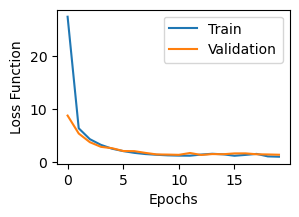

In [84]:
# Set the figure size and dpi for the plot
plt.figure(figsize=(3, 2), dpi=100)

# Plot the training loss over epochs
plt.plot(np.array(history.history['loss']), label='Training Loss')

# Plot the validation loss over epochs
plt.plot(np.array(history.history['val_loss']), label='Validation Loss')

# Set labels for the axes
plt.ylabel('Loss Function')
plt.xlabel('Epochs')

# Add a legend to identify the lines in the plot
plt.legend(['Train', 'Validation'], loc='best')

# Display the plot
plt.show()

In [85]:
# Evaluate the model on the validation data
evaluation_results = model.evaluate(x_val, y_val)

# Print or use the evaluation results as needed
print("Evaluation Results:", evaluation_results)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6927 - loss: 1.3623
Evaluation Results: [1.4454749822616577, 0.6903333067893982]


In [86]:
# Make predictions using the trained model on the validation data
y_pred = model.predict(x_val)

# Display the shape of the predicted values
print("Shape of Predicted Values:", y_pred.shape)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Shape of Predicted Values: (3000, 10)


In [88]:

# Get the indices of the maximum values along axis 1 for predicted values
prediction = np.argmax(y_pred, axis=1)

# Get the indices of the maximum values along axis 1 for actual values (ground truth)
actual = np.argmax(y_val, axis=1)

In [89]:
# Calculating F1 Score using the macro average method
f1 = f1_score(actual, prediction, average='macro')

# Calculating accuracy score
accuracy = accuracy_score(actual, prediction)

# Calculating precision using the macro average method
precision = precision_score(actual, prediction, average='macro')

# Calculating recall using the macro average method
recall = recall_score(actual, prediction, average='macro')

# Printing the computed metrics
print('F1 Score:', f1)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)

F1 Score: 0.7166914828686857
Accuracy: 0.6903333333333334
Precision: 0.7476013477172536
Recall: 0.733434922343751


#Visualization

In [102]:
# Creating a confusion matrix using actual and predicted values
cmat = confusion_matrix(actual, prediction)


In [100]:
def plot_confusion_matrix(cmat, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cmat = cmat.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cmat)

    thresh = cmat.max() / 2.
    for i, j in itertools.product(range(cmat.shape[0]), range(cmat.shape[1])):
        plt.text(j, i, cmat[i, j],
            horizontalalignment="center",
            color="white" if cmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[168   7   7 334   1  15  55   5   0   0]
 [  0 279   3  12   0  13   0   0   0   0]
 [  3   8 216   6   7  13  20  27   4   0]
 [  7   5   9 105  13  17  26  66   6   0]
 [  1   0   0   5 214   0   0  33   1   0]
 [  2  22   8  23   0 141   9   0   0   0]
 [  9   0   8  15   0   8 192  24   1   0]
 [  0   0   3   2   7   2   3 261   0   0]
 [  1   2   9  22   4   3   1   8 220   2]
 [  0   0   0   0   0   0   0   0   2 275]]


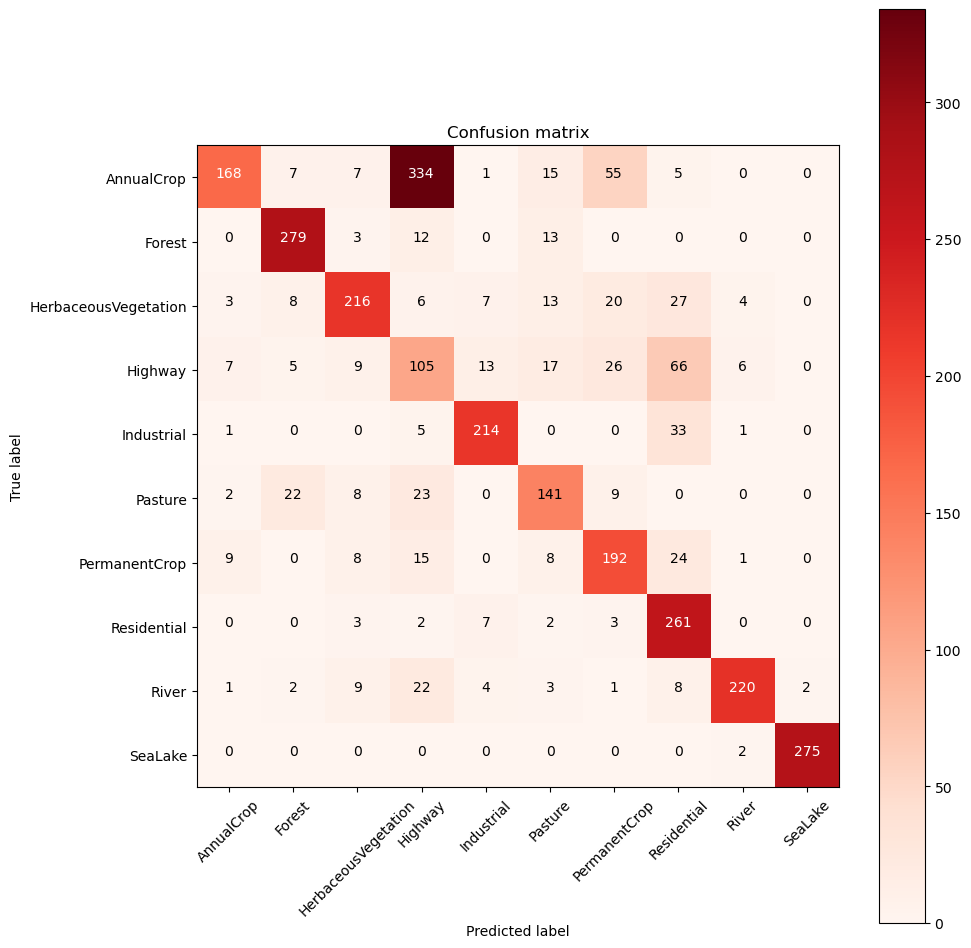

In [101]:
plot_confusion_matrix(cmat, classes, cmap='Reds')